# 10. 인공지능으로 세상에 없던 새로운 패션 만들기

## 10-14.프로젝트 : CIFAR-10 이미지 생성하기

---

### 목차
- STEP 1. 작업환경 구성하기
- STEP 2. 데이터셋 구성하기
- STEP 3. 생성자 모델 구현하기
- STEP 4. 판별자 모델 구현하기
- STEP 5. 손실함수와 최적화 함수 구현하기
- STEP 6. 훈련과정 상세 기능 구현하기
- STEP 7. 학습 과정 진행하기
- STEP 8. (optional) GAN 훈련 과정 개선하기

---

### STEP 1. 작업환경 구성하기

- dcgan_newimage/cifar10/generated_samples
- dcgan_newimage/cifar10/training_checkpoints
- dcgan_newimage/cifar10/training_history

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### STEP 2. 데이터셋 구성하기
- CIFAR-10 데이터셋: tr.keras.datasets.cifar10.load_data()
- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

#### 1. 데이터셋 가져오기
- [CIFAR-10 데이터셋 구성](https://keras.io/api/datasets/cifar10/)

[![](http://solarisailab.com/wp-content/uploads/2017/06/cifar-10_labels.png)](https://www.cs.toronto.edu/~kriz/cifar.html)

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [4]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


#### 2. 각 픽셀을 [-1, 1]로 정규화

- [0,1]이 아니라 [-1,1]로 정규화하는 이유?
    - 중간값을 0으로 맞춤
    - 생성자 모델 마지막 레이어에서 activation='tanh'를 사용함
    - tanh와 모양을 맞추기 위함
    - [0,1]을 사용할 경우, 값을 절반밖에 사용하지 못하기 때문

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


#### 3. 데이터 확인

- 이미지 색깔 정상적으로 출력하는 방법
    - 그냥 train_x[0] 를 plt.imshow()로 출력할 경우 아래와 같은 문구가 뜸, 색깔이 파랗게 나옴
    ```
    Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    ```
    => 해결? train_x 를 앞에서 [-1,1] 범위로 정규화 했기 때문에 [0,1] 범위로 만들어서 출력하면 된다!
    => (train_x[0]+1)/2 값으로 plt.imshow()로 출력하면 정상적으로 나옴!
    - plt.imshow() 에서 cmap 인자값을 주지 않음!

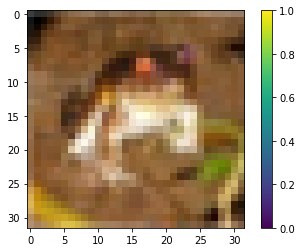

In [6]:
plt.imshow((train_x[0]+1)/2)
plt.colorbar()
plt.show()

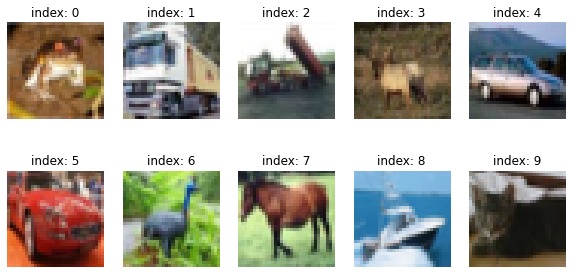

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

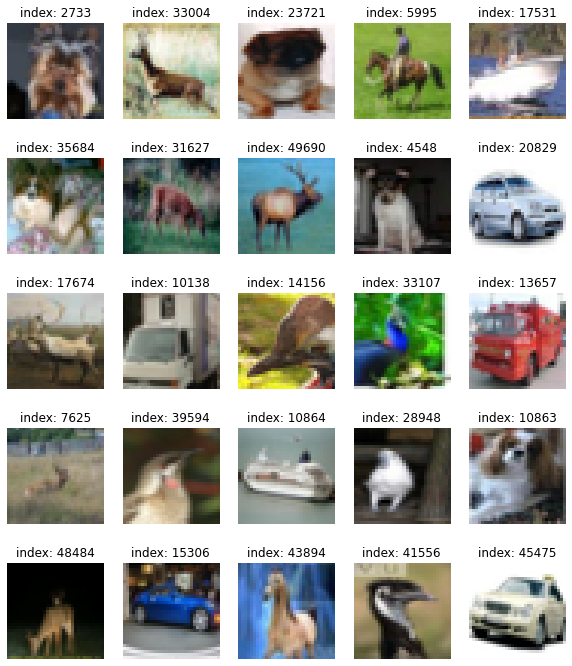

In [8]:
import random

plt.figure(figsize=(10, 12))

for i in range(25):
    # [[YOUR CODE]]
    plt.subplot(5, 5, i+1)
    np.random.seed(i)  # seed 로 고정된 랜덤 사용
    random_i = np.random.randint(1, len(train_x))
    plt.imshow((train_x[random_i]+1)/2)
    plt.title(f'index: {random_i}')
    plt.axis('off')

plt.show()

#### 4. 데이터 섞기
- BUFFER_SIZE
    - 전체 데이터를 섞기(shuffle() 함수 사용) 위함
    - 데이터가 잘 섞이려면 BUFFER_SIZE 를 총 데이터 사이즈와 같거나 크게 설정해야 좋다.
- BATCH_SIZE
    - 모델이 한 번에 학습할 데이터의 양 => 미니 배치 학습
    - 너무 많은 양을 한번에 학습시키면 메모리 활용 비효율적, 한 번 학습하는데 오래 걸림
- tf.data.Dataset.from_tensor_slices(): 리스트, 넘파이, 텐서플로우의 텐서 자료형에서 데이터셋 생성

In [9]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 256  # 미니 배치 학습

In [10]:
# numpy ndarray(train_x): 자료를 섞고 배치 사이즈에 따라 나눔
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

#### 1. DCGAN

- Generator model
    - Conv2DTranspose layer
        - Conv2D 와 반대로 image size 를 넓히는 층
        - (8,8,256) -> (16,16,64) -> (32,32,3)
    - BatchNormalization layer
        - 신경망의 weight explosion 을 막기 위해 가중치 정규화
    - activation function
        - 중간 층 활성화 함수: LeakyReLU
        - 마지막 층 활성화 함수: tanh
            - 입력 픽셀이 [-1,1]로 정규화되어 있기 때문
- shape 맞추기
    - input.shape => (32,32,3)
        - => 32 = 4x
        - => x = 8
    - model output 의 shape 도 똑같이 맞춰줘야 함!
        - output channel = 3

In [11]:
# 생성자 생성 함수
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

#### 2. random noise vector 로 랜덤 이미지 생성

- tf.random.normal([1, 100]): shape=(1,100)이고 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터 생성

In [13]:
noise = tf.random.normal([1, 100])

- generator(noise, training=False)
    - 내부적으로 call 함수가 호출되어 입력값으로 noise 를 넣으면 간단히 결과 이미지가 생성된다!
    - 학습하는 중이 아니므로 training=False (Batch Normalization layer 의 훈련 시기와 추론 시기 행동이 다르기 때문)
    - shape => TensorShape([1, 32, 32, 3]) => TensorShape([batch_size(1), image(32,32,1)])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape  # TensorShape([1, 32, 32, 3]) # [batch_size(1), image(32,32,1)]

TensorShape([1, 32, 32, 3])

- plt.imshow((generated_image[0, :, :, 0]+1)/2)
    - matplotlib library 는 2차원 이미지만 보여줄 수 있음
    - => 0번째, 3번째 축 인덱스를 0 으로 설정해서 (32,32) shape 이미지를 꺼내야 함!
    - => 아직 모델이 학습하지 않은 상태라서 아무 의미없는 이미지가 생성됨

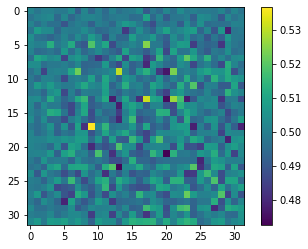

In [15]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

#### DCGAN
- Discriminator model
    - Conv2D layer
        - Conv2DTranspose 와 반대로 image size 를 줄이는 층
        - (32,32,3) -> (16,16,64) -> (8,8,128)
    - 마지막 층 Flatten layer
        - 3차원 이미지 -> 1차원 이미지 변환
        - => (1, 8*8*128) => (1,8192) vector 로 변환
    - activation function
        - 중간 층 활성화 함수: LeakyReLU
        - 마지막 층 활성화 함수: 無
            - sigmoid or tanh 없음 => 값을 정규화시키지 않음 => 출력값의 범위가 정해지지 않음 => 출력값은 모든 범위의 실수값을 가진다.
- 입력 및 출력
    - input: (32,32,3) 이미지(가짜 이미지, 진짜 이미지)
    - output: 숫자 1개(진짜라고 판단되는 정도)

In [16]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1))

    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

- discriminator(generated_image, training=False)
    - 가짜 이미지 입력 => 텐서플로우의 텐서 형태로 출력됨
    - 학습하는 중이 아니므로 training=False => 출력값 아무 의미 없음

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00058367]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 - 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

#### 1. 손실 함수(loss function)
- 교차 엔트로피(cross_entrophy)
    - 분류 모델 설계할 때 많이 사용
    - 점점 가까워지기를 원하는 두 값이 얼마나 큰 차이가 나는지 정량적으로 계산할 때 사용
    - 판별자는 이진 교차 엔트로피(binary cross entropy) 사용
        - fake, real 을 나타내는 class 2개 분류 문제를 풀어야 하기 때문

- 손실함수를 이용해 정량적으로 달성해야 하는 목표
    - Real image label 1, Fake image label 0
    - 생성자 or 판별자 손실함수 입력값 = 판별자의 판별값
        - 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 `D(fake_image)` 값이 1에 가까워지는 것
            - 목적: fake 를 real 로 속이기
        - 판별자 : Real Image 판별값, 즉 `D(real_image)`는 `1`에, Fake Image 판별값, 즉 `D(fake_image)`는 `0`에 가까워지는 것
            - 목적: fake, real 잘 판별하기

- tf.keras.losses.BinaryCrossentropy(from_logits=True)
    - tf.keras.losses.BinaryCrossEntropy 클래스는 input value 가 [0,1] 분포 확률값이어야 함
    - from_logits=True 로 입력값을 함수 내부에서 sigmoid 를 사용해서 [0,1]로 정규화 함
        - 판별자의 마지막 층에 활성화 함수 없음 => 결과값이 모든 범위의 실수값이 됨

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- cross_entropy 에서 활용할 값
    - `fake_output` : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 `D(fake_image)`
    - `real_output` : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 `D(real_image)`

- 비교 방법
    - tf.ones_like(벡터): input 벡터와 동일한 크기면서 값이 1로 채워진 벡터
    - tf.zeros_like(벡터): input 벡터와 동일한 크기면서 값이 0으로 채워진 벡터

- generator_loss
    - `generator_loss` 는 `fake_output` 가 1에 가까워지기를 바람
    - => `cross_entropy(tf.ones_like(fake_output), fake_output)` 값은 fake_output 이 (Real Image 를 의미하는) 1에 가까울수록 작은 값을 가짐

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- discriminator_loss
    - `discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바람
    - => `real_output`은 1로 채워진 벡터와, `fake_output`은 0으로 채워진 벡터와 비교
    - => 최종 `discriminator_loss` 값 = 이 둘을 더한 값

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- discriminator accuracy
    - 판별자가 real output, fake output 을 얼마나 정확히 판별하는지의 각각 따로 accuracy 를 계산해서 비교해보는 것이 중요함
    - 판별자가 real output 과 fake output 을 accuracy 가 1.0 에 가까울 정도로 정확하게 판별하는 것은 좋지 않다. 생성자가 만들어내는 fake output 이 real output 과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻!
    - => real accuracy 와 fake accuracy 는 초반에는 1.0 에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5 에 가까워지는 것이 이상적
    - tensorflow 함수
        - (1) tf.math.greater_equal(입력, 값): 판별(입력의 각 원소가 값보다 크거나 같으면 True, 아니면 False)
        - (2) tf.cast((1), tf.float32): (1) 결과 True 면 1.0, False 면 0.0 변환
        - (3) tf.reduce_mean((2)): (2) 결과를 평균내서 배치 정확도 계산

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

#### 2. 최적화 함수(optimizer)

- Optimizer 종류
    - 출처: 하용호, 자습해도 모르겠던 딥러닝, 머리속에 인스톨 시켜드립니다
    [![optimizer summary](https://image.slidesharecdn.com/random-170910154045/95/-49-638.jpg?cb=1505089848)](https://sacko.tistory.com/42)
- Adam 최적화 기법 사용
    - tf.keras.optimizers.Adam()
    - 하이퍼 파라미터 learning rate 을 0.0001 -> 변경해보면서 학습 진행 후 확인하기
    - 생성자, 판별자는 개별 네트워크라서 optimizer 를 따로 생성해야 함

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- 생성자가 생성한 샘플 확인

In [24]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

#### 훈련 과정 처리 함수 구현

cf. 텐서플로 2.0 이후 부터는 1.x 버전과 다르게 session 사용X => @tf.function 데코레이터를 붙여서 사용
=> Tensorflow 의 graph 노드가 될 수 있는 타입으로 자동 변환됨

- train_step()  # 한 단계 학습
    - (1) 입력 데이터: Real Image 역할을 할 `images` 한 세트를 입력으로 받음
    - (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 `noise`를 `images` 한 세트와 같은 크기인 `BATCH_SIZE` 만큼 생성함
    - (3) `tf.GradientTape()`는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 `with` 구문 열기
    - (4) generated_images 생성 : generator가 `noise`를 입력받은 후 `generated_images` 생성
    - (5) discriminator 판별 : discriminator가 Real Image인 `images`와 Fake Image인 `generated_images`를 각각 입력받은 후 `real_output`, `fake_output` 출력
    - (6) loss 계산 : `fake_output`, `real_output`으로 generator와 discriminator 각각의 loss 계산
    - (7) accuracy 계산 : `fake_output`, `real_output`으로 discriminator의 정확도 계산
    - (8) gradient 계산 : `gen_tape`와 `disc_tape`를 활용해 gradient를 자동으로 계산
    - (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
    - (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- generate_and_save_image()  # 샘플 이미지 생성 및 저장
    - 일정 간격으로 학습 현황을 볼 수 있는 샘플 생성 함수
    - 앞서 만든 고정된 seed 에 대한 결과물이 얼마나 나아지고 있는지 확인

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds, save_file_num=1):

    predictions = model(sample_seeds, training=False)  # 16개의 seed 가 들어있는 sample_seeds
    
    # [-1,1]로 정규화된 이미지를 원상복구함
    rescue_predictions = (predictions.numpy() * 127.5 + 127.5).astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)  # 16개 sample 이라서 4행 4열로 시각화
        plt.imshow(rescue_predictions[i])  # plt.imshow(np.array(predictions[i, :, :, :]*127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)

    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/generated_samples/sample_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

- draw_train_history()  # 학습 과정 시각화
    - loss 와 accuracy 그래프 그리기
    - => `train_step()` 함수가 리턴하는 4가지 값(`gen_loss`, `disc_loss`, `real_accuracy`, `fake_accuracy`)을 dict 구조 history 변수에 리스트로 저장 -> 매 epoch 마다 시각화
    - cf. GAN의 학습 과정은 지도학습 모델보다 까다로움 => 두 모델(생성자, 판별자)이 서로의 학습 과정에 영향을 주고받기 때문

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch, save_file_num=1):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')

    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    save_file_path = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_history/train_history_{}'.format(save_file_num)
    if not os.path.exists(save_file_path):
        os.makedirs(save_file_path)
    
    save_file_path = os.path.join(save_file_path, 'train_history_{:04d}.png'.format(epoch))
    plt.savefig(save_file_path)  # 이미지 저장

    plt.show()

- tf.train.Checkpoint()  # 모델 저장
    - 모델 저장 및 버전 관리
    - optimizer, Generator, Discriminator 모두 넣어서 저장 => 생성자, 판별자가 학습한 모델 가중치 저장

In [28]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

#### 1. 모델 학습 함수: train(데이터, 학습횟수, 모델저장간격)
- train_step(): 한 단계 학습
- generate_and_save_images(): 샘플 이미지 생성 및 저장
- draw_train_history(): 학습 과정 시각화
- checkpoint: 모델 저장

In [29]:
def train(dataset, epochs, save_every, save_file_num=1):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed, save_file_num)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
            checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed, save_file_num)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch, save_file_num)

In [30]:
save_every = 5  # 모델 저장 간격
EPOCHS = 50  # 학습 횟수

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### 2. 모델 학습 진행

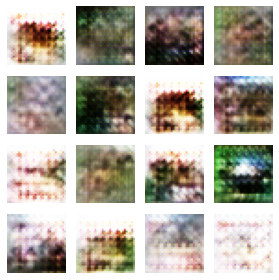

Time for training : 636 sec


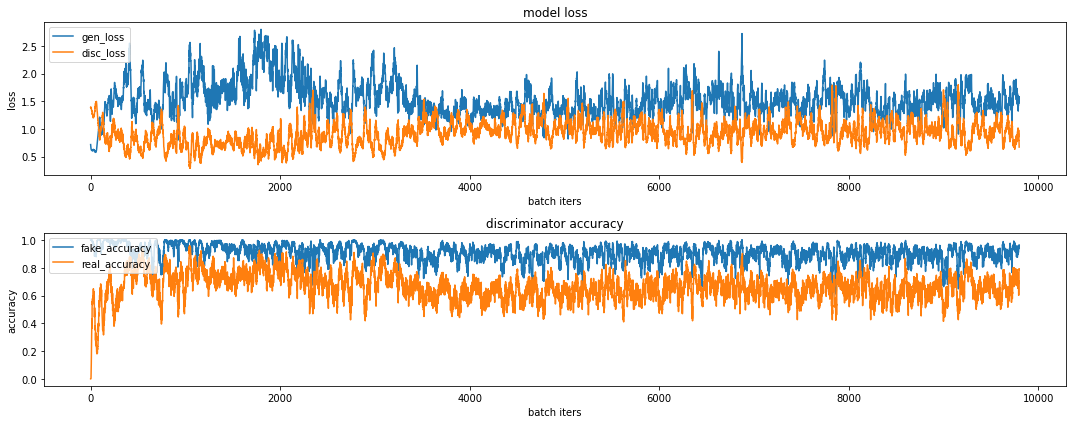

CPU times: user 9min 24s, sys: 1min 15s, total: 10min 39s
Wall time: 10min 37s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every, 1)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [32]:
def make_a_gif(anim_file_num=1, flag=True):
    if flag:
        anim_file = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/gif/cifar10_dcgan_{}.gif'.format(anim_file_num)
        filenames = glob.glob('drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/generated_samples/sample_{}/sample*.png'.format(anim_file_num))  # Fake Images
    else:
        anim_file = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/gif/cifar10_dcgan_history_{}.gif'.format(anim_file_num)
        filenames = glob.glob('drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_history/train_history_{}/train_history*.png'.format(anim_file_num))  # Graphs

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [33]:
# Fake Images to GIF
make_a_gif(1, True)

In [34]:
# History Graphs to GIF
make_a_gif(1, False)

- (참고) 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.
아래는 checkpoint 모듈을 활용하여 모델을 로드하는 예시입니다.

In [35]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    # 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  # subplot 간격 자동 조절(겹치지 않게)
    plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

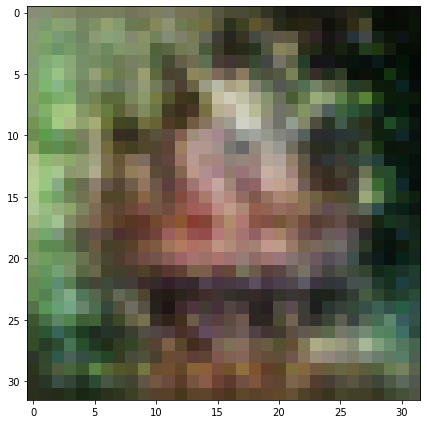

In [36]:
draw_training_checkpoints_image(1)

### STEP 8. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.

    - [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
    - [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)
    - [Tips for Training Stable Generative Adversarial Networks](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
    - [Improved Techniques for Training GANs(paper)](https://papers.nips.cc/paper/6125-improved-techniques-for-training-gans.pdf)

#### 1. 문제 분석
- 문제
    - fake image 가 무엇을 만들어 낸 것인지 분간이 가지 않음 => 형체가 없음
- 해결
    - epoch 증가
    - 하이퍼 파라미터 변경

#### 2. 개선 1
- 단순하게 epoch 500 으로 변경해서 실행
- 체크포인트 복구해서 이미지 생성

In [37]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

In [38]:
# 체크 포인트 복구
checkpoint_dir = 'drive/MyDrive/Colab Notebooks/dcgan_newimage/cifar10/training_checkpints/training_checkpoints_1'
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

generator = checkpoint.generator
discriminator = checkpoint.discriminator

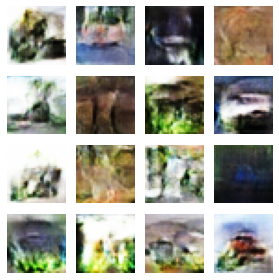

Time for training : 7034 sec


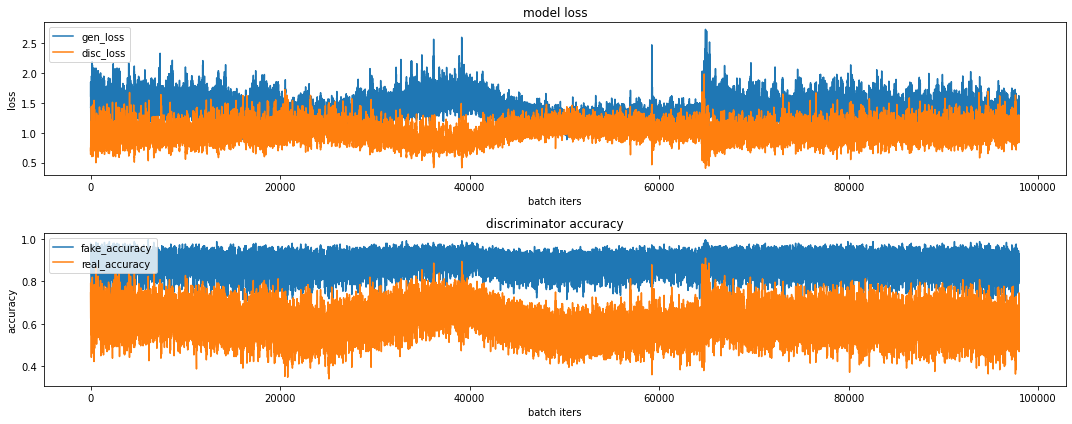

CPU times: user 1h 47min 34s, sys: 12min 20s, total: 1h 59min 54s
Wall time: 1h 57min 20s


In [39]:
%%time
train(train_dataset, EPOCHS, save_every, 2)

In [40]:
# Fake Images to GIF
make_a_gif(2, True)

In [ ]:
# History Graphs to GIF
make_a_gif(2, False)

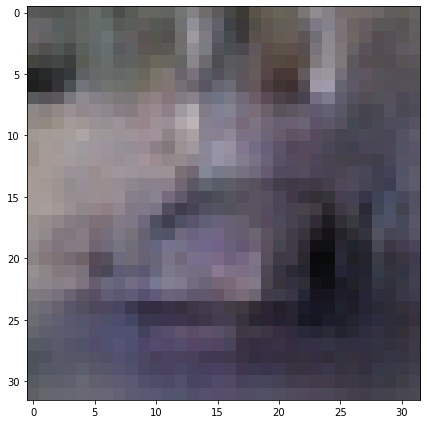

In [42]:
draw_training_checkpoints_image(2)

#### 3. 개선 2 [[참고]](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
- 체크포인트 복구 없이 이미지 생성
- batch_size = 128
  - 주의: batch_size 값을 변경했기 때문에 관련 변수, 함수를 다시 선언해줘야 오류가 발생하지 않음!!
- epochs = 500
- optimizer: Adam
  - cifar 10 에서 AMSgrad 가 효과적이라는 말이 있어서 사용 [[참고]](https://tgd.kr/c/deeplearning/19860071)
  - learning_rate = 0.0002 => 2e-4
  - beta_1 = 0.5

```python
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
```

- 레이어 관련 설정 [[참고1]](https://towardsdatascience.com/dcgans-generating-dog-images-with-tensorflow-and-keras-fb51a1071432) [[참고2]](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)
  - Generator Model
    - Conv2DTranspose layer 층 3개 -> 5개로 증설
    - g_kernel_size = 4
    - g_LeakyReLU_alpha = 0.2
  - Discriminator Model
    - Conv2D layer 총 2개 -> 4개로 증설
    - d_kernel_size = 3
    - d_LeakyReLU_alpha = 0.2
    - d_dropout_rate = 0.5
    - 마지막 Dense layer 에서 활성화 함수 sigmoid 적용
    
```python
model.add(layers.Dense(1, activation='sigmoid'))
```

In [43]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [44]:
BUFFER_SIZE = 50000  # len(train_x) == 50000
BATCH_SIZE = 128  # 미니 배치 학습

In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [46]:
# 생성자 생성 함수
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [47]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 512)        2097152   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 512)       

In [48]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [49]:
def make_discriminator_model():

    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [50]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

In [51]:
decision = discriminator(generated_image, training=False)

In [52]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [53]:
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)

In [54]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

TensorShape([16, 100])

In [55]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [60]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [56]:
save_every = 5  # 모델 저장 간격
EPOCHS = 500  # 학습 횟수

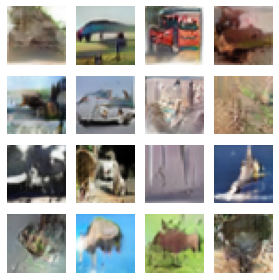

Time for training : 25423 sec


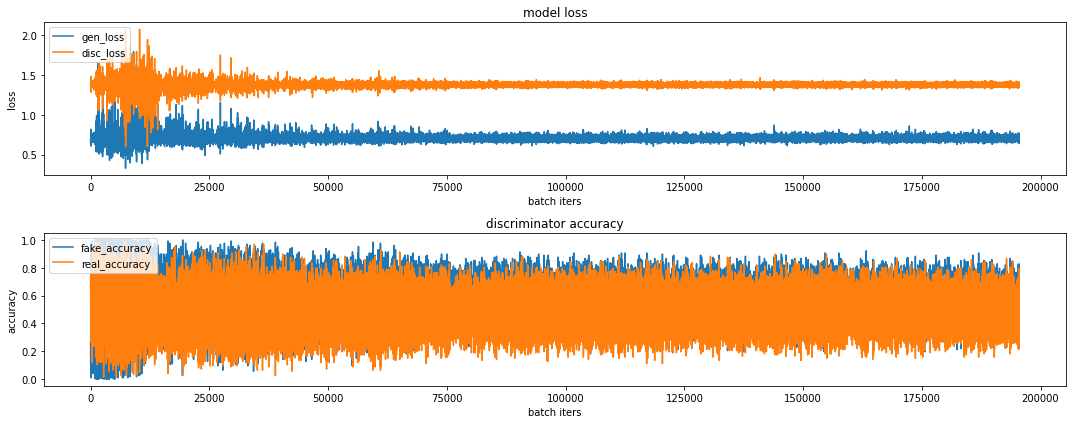

In [61]:
train(train_dataset, EPOCHS, save_every, 3)

In [62]:
# Fake Images to GIF
make_a_gif(3, True)

In [63]:
# History Graphs to GIF
make_a_gif(3, False)

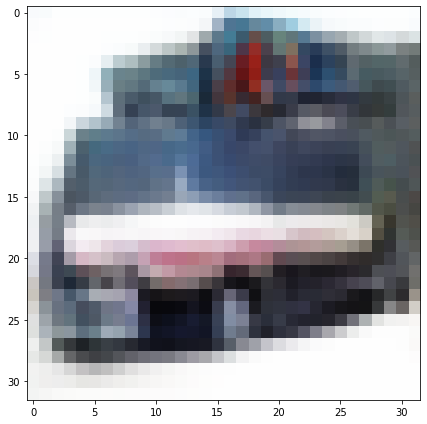

In [69]:
draw_training_checkpoints_image(3)

---

## 결과 정리

- Real Images: [CIFAR-10](https://keras.io/api/datasets/cifar10/)

|0: airplane|1: automobile|2: bird|3: cat|4: deer|
|:---:|:---:|:---:|:---:|:---:|
|![](get_cifar10_images/airplane.png)|![](get_cifar10_images/automobile.png)|![](get_cifar10_images/bird.png)|![](get_cifar10_images/cat.png)|![](get_cifar10_images/deer.png)|

|5: dog|6: frog|7: horse|8: ship|9: truck|
|:---:|:---:|:---:|:---:|:---:|
|![](get_cifar10_images/dog.png)|![](get_cifar10_images/frog.png)|![](get_cifar10_images/horse.png)|![](get_cifar10_images/ship.png)|![](get_cifar10_images/truck.png)|


- Fake Images by DCGAN
    - (LMS 결과) LMS 기본 코드로 나온 이미지는 형체가 없어서 무엇을 만들었는지 알 수 없음. 학습 시간 총 10min 37s 걸림
    - (개선1) epoch을 500으로 늘리고 앞서 저장한 checkpoint를 불러와서 이미지를 이어서 만들었음. 선명해지면서 형체가 보이기 시작. 그러나 fake accuracy 값이 떨어지지 않음. 학습 시간 총 1h 57min 20s 걸림
    - (개선2) checkpoint를 불러오지 않고 새로 이미지 생성. 여러 파라미터 값을 바꾸고 레이어 층을 더 쌓음. real image 를 토대로 제대로 된 fake image 를 얻음. real accuracy 와 fake accuracy 가 0.5 를 향해 하향하고 있음. 학습 시간 총 7h 3min 43s 걸림
    
|-|Total Learning Time|Setting|
|:---:|:---:|---|
|**LMS 결과**|10min 37s|default|
|**개선1**|1h 57min 20s|checkpoint 불러오기, epoch=500|
|**개선2**|7h 3min 43s|checkpoint 불러오기X, epoch=500, batch_size=128, optimizer.Adam(learning_rate=2e-4, beta_1=0.5, amsgrad=True), Generator Model(Conv2DTranspose layer 5개, g_kernel_size=4, g_LeakyReLU_alpha=0.2), Discriminator Model(Conv2D layer 4개, d_kernel_size=3, d_LeakyReLU_alpha=0.2, d_dropout_rate=0.5, 마지막 Dense layer에 activation='sigmoid' 적용)|

|-|LMS 결과|개선1|개선2|
|:---:|:---:|:---:|:---:|
|**Image PNG**|![](dcgan_newimage/cifar10/generated_samples/sample_1/sample_epoch_0050_iter_195.png)|![](dcgan_newimage/cifar10/generated_samples/sample_2/sample_epoch_0500_iter_195.png)|![](dcgan_newimage/cifar10/generated_samples/sample_3/sample_epoch_0500_iter_390.png)|
|**Image GIF**|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_1.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_2.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_3.gif)|
|**History PNG**|![](dcgan_newimage/cifar10/training_history/train_history_1/train_history_0049.png)|![](dcgan_newimage/cifar10/training_history/train_history_2/train_history_0499.png)|![](dcgan_newimage/cifar10/training_history/train_history_3/train_history_0499.png)|
|**History GIF**|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_1.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_2.gif)|![](dcgan_newimage/cifar10/gif/cifar10_dcgan_history_3.gif)|


- 결론
    - **망한 그림을 이어서 그리는 것(=checkpoint 활용)보다 학습 시간이 오래 걸리더라도 처음부터 새로 그리는 것(=checkpoint 활용X)이 정답이었다.**
    - 레이어 쌓기(=특징을 얼마나 많이 잡아낼 것인가)와 파라미터 값 변경(=잡아낸 특징을 어떤 비율로 어떻게 처리할 것인가) 중에서 전자가 더 중요한 것 같다.

---

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.
cifar10 기본 해상도가 낮아서 그런지 형체가 있는 fake image 를 생성하는 것이 쉽지 않았다. shape 계산이 익숙하지 않아서 레이어를 쌓아보지 못한 점이 아쉽다.

### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
1. 양방향 CycleGAN 은 label이 필요없다. => y_train, y_test 사용X
2. GAN(Generative Adversarial Network) => minmax game [[참고1: GAN: Generative Adversarial Networks (꼼꼼한 딥러닝 논문 리뷰와 코드 실습)]](https://youtu.be/AVvlDmhHgC4) [[참고2: <외부기고> [새로운 인공지능 기술 GAN] ② GAN의 개념과 이해]](https://www.samsungsds.com/kr/insights/Generative-adversarial-network-AI-2.html)
<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fp6awY%2FbtqNWfQIyba%2FuVyGY7lgiPCmRYolnKVO30%2Fimg.png)
    - $\underset {G}{min} \underset {D}{max} V(D,G) = E_{x \sim p_{data}(x)}[logD(x)]+E_{z \sim p_z(z)}[log(1-D(G(z)))]$
    - 오직 Neural Network 만 사용하는 것이 특징
        - => 일반적으로 사용되는 딥러닝 기술 적용 가능 e.g. Dropout, ReLU
        - 미분 가능
    - 생성자(Generator)
        - 학습이 끝나면 생성자 분포는 원본 데이터 분포에 수렴할 수 있게 된다. $Fixed~G => the~optimal~D => C(G)=\underset {D}{max} V(G,D)=-log{4} => P_g = P_{data} => global~minima$
        - 아무 의미 없는 random noise 로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성
            - noise vector: uniform 이든 gaussian 이든 원하는 것 사용 가능!
        - 무에서 유를 창조
        - 속이는 역할(counterfeiter, 위조지폐 위조범) => min
    - 판별자(Discriminator)
        - 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 real 인지(1), fake 인지(0) 판단 정도를 실수값으로 출력
        - 속지 않으려는 역할(police, 경찰) => max
3. [DCGAN(Deep Convolution GAN)](https://www.tensorflow.org/tutorials/generative/dcgan?hl=en)
    - GAN 개선시키고 Convolution 을 적용한 모델 => 고화질 이미지 생성을 이루어냄 [[참고1: [GAN] DCGAN - 논문 리뷰, Paper Review, 설명 (1)]](https://memesoo99.tistory.com/32) [[참고2: [GAN] DCGAN - 논문 리뷰, Paper Review, 설명 (2)]](https://memesoo99.tistory.com/33)
        - 3가지 특징을 지닌 CNN 구조 적용
            - 1. Max Pooling To Strided Convolution
            - 2. Eliminate Fully-Connected Layers
                - G 에 noise vector z 를 넣는 첫 번째 layer 에서 FC layer 제거
                - D 에 output 결과를 판단하는 마지막 sofxmax layer 를 제외하고는 FC layer 제거
            - 3. [Batch Normalization](https://eehoeskrap.tistory.com/430) 추가
                - deep model 에서도 Gradient 가 잘 흐르게 BN 적용
                - G 의 output layer, D 의 input layer 에는 BN 을 넣지 않음
    - 이후 발표된 GAN 기반 이미지 생성 모델은 대부분 DCGAN 모델을 발전시킨 형태
    - [Tip](https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/)
      - The tips draw upon the suggestions from the DCGAN paper as well as elsewhere.
      - A summary of some of the more actionable tips is provided below.
        - Normalize inputs to the range [-1, 1] and use tanh in the generator output.
        - Flip the labels and loss function when training the generator.
        - Sample Gaussian random numbers as input to the generator.
        - Use mini batches of all real or all fake for calculating batch norm statistics.
        - Use Leaky ReLU in the generator and discriminator.
        - Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling.
        - Use label smoothing in the discriminator, with small random noise.
        - Add random noise to the labels in the discriminator.
        - Use DCGAN architecture, unless you have a good reason not to.
        - A loss of 0.0 in the discriminator is a failure mode.
        - If loss of the generator steadily decreases, it is likely fooling the discriminator with garbage images.
        - Use labels if you have them.
        - Add noise to inputs to the discriminator and decay the noise over time.
        - Use dropout of 50 percent during train and generation.
3. GAN History
  - [GAN-based Model](https://happy-jihye.github.io/gan/gan-25/)<br>![](https://github.com/happy-jihye/happy-jihye.github.io/blob/master/_posts/images/gan/ai-content-creation-1.png?raw=1)
  - [Taxnomoy of GAN](https://roytravel.tistory.com/109)<br>![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FL7afg%2Fbtre2eX38nW%2FYfepfjkmUZ4pP73XarTymk%2Fimg.png)
4. [Activation Function](https://newly0513.tistory.com/20)<br>[![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fc554eP%2Fbtq7UJytKVJ%2FsZUiOboAYGQSWaeM8TlRs0%2Fimg.png)](https://memesoo99.tistory.com/7)
5. 이미지 픽셀을 [-1,1]로 정규화했기 때문에 생성자 모델에서 활성화 함수 tanh를 사용함
6. 이미지 픽셀을 [-1,1]로 정규화했기 때문에 결과로 파란 이미지만 출력되었음 => 다시 원상태로 복구해서 제대로 컬러 이미지를 출력시켰다.

```python
# [-1,1] 정규화 코드 예시
train_x = (train_x - 127.5) / 127.5  # 이미지를 [-1, 1]로 정규화합니다.

# [-1,1] 정규화 복구 코드 예시
np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
```


### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.

>#### **루브릭**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1|GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.|
>|2|생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.|
>|3|추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.|

Generator 와 Discriminator 로 fake image 를 만들어 보았다. 기존의 lms 코드로 얻은 cifar10 의 fake image 는 형체가 없어서 구분하기 어려웠다. 그래서 epoch 을 늘려보고 하이퍼 파라미터를 조정해서 육안으로 구별할 수 있는 fake image 를 얻었다.

결과 이미지(fake image)를 보면 점점 품질이 높아져서 어느덧 형체가 제대로 잡혀 있었다. 그래프를 보면 real accuracy 와 함께 fake accuracy 가 점점 0.5 를 향해 하향하고 있음을 볼 수 있다.

epoch 500 으로 늘리고 앞서 만들어진 checkpoint 를 불러와서 만든 경우(개선1)와 checkpoint 를 불러오지 않고 DCGAN 의 적절한 하이퍼 파라미터 값을 설정한 경우(개선2)를 비교해보면 확실히 점점 갈수록 더 선명해지고 real image 를 기반으로 새로운 fake image 가 만들어지는 것을 확인할 수 있었다.


### - 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
없음

### - **자기 다짐**
다른 GAN 모델(e.g. StyleGAN v2, BigBiGAN)이 뭐가 있는지 찾아보고 각 모델별 연구목적과 핵심 원리를 파악해서 적용하는 방법을 알아봐야 겠다.